# Level 1 Requirement Flowdown Overview

## L1-1 Global Point Sources

> Carbon-I shall detect point sources exceeding **175 kg/hr of CH₄**, **100 metric tons/hr of CO₂**, and **1.75 metric tons/hr of CO** for the Nominal Scenario¹

Observation Modes: Global and Glint Modes

¹: Nominal Scenario defines a typical scene with a spectrally flat 15% albedo (Table E.1-2).

Set up the programming environment

In [1]:
# This Cell is used to set up the environment for the Carbon-I Open Source project.
include("setup-level1-packages.jl")
# This includes our Carbon-I and vSmartMOM packages (developed by our team)

  Activating project at `~/code/gitHub/CarbonI`
┌ Info: CUDA-enabled GPU(s) detected
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:57
┌ Info: CUDA.CuDevice(0): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:59
┌ Info: CUDA.CuDevice(1): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:59


req_vs_exp_table

### Define Requirements with corresponding units:

We utilize Julia's Unitful package here, which allows for automated unit conversion and propagation of units for any computation. 

In [2]:
# Define Requirements with corresponding units:# Flux limits:
flux_detect_ch4_req = 175.0u"kg/hr"    # in kg CH₄/hr
flux_detect_co2_req = 100e3u"kg/hr"    # in kg CO₂/hr
flux_detect_co_req  = 1.75e3u"kg/hr"   # in kg CO/hr

# Specify Ground Sampling Distance GSD in along x cross track directions, for Required and CBE cases:
gsd_req  = [400.0u"m", 400.0u"m"]      # in m
gsd_cbe  = [303.0u"m", 345.0u"m"]      # in m

2-element Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}:
 303.0 m
 345.0 m

In [3]:
# Compute effective pixel sizes as the square root of the product of along and cross track GSDs:
req_pix = sqrt(prod(gsd_req));
cbe_pix = sqrt(prod(gsd_cbe));

## Theoretical basis for the requirement

### Point-Source Detectability (L1-1/L1-2)

Under the Jacob framework, the minimum detectable emission rate is:

$$
Q_{\min} \;=\; 
\underbrace{\frac{M_{\mathrm{gas}}}{M_{\mathrm{DryAir}}}\,\frac{\sigma_s\,p}{g}}_{\sigma_s^\ast\ \text{(amount/area)}}
\; \times \; q \, U \, W. \tag{D–3}
$$

where  
- $ \sigma_s $ is the single-pixel column precision,  
- $ M_{\mathrm{gas}} $ and $ M_{\mathrm{dry}} $ are the molar masses of the target gas and dry air, respectively,  
- $ p $ is surface pressure, $ g $ is gravitational acceleration,  
- $ q $ is the detection scalar (we take $ q = 2 $),  
- $ U $ is the wind speed, and  
- $ W $ is the ground sampling distance (GSD).

Thus, detection is primarily governed by the product $ \sigma_s \times W $ at a given wind $U$ and factor $q$ (2 for detection, 5 for quantification) . Finer ground sampling and lower per-pixel noise jointly reduce \( Q_{\min} \).
Starting from the Jacob relation, the minimum detectable emission rate is

---

### Flowdown to a requirement on $ \sigma_s $ (or $ \sigma_s \times W $)

Rearranging (D–3) gives a requirement on the product $ \sigma_s W $ for fixed $ U $ and $ q $:

$$
\sigma_{s}^{\mathrm{req}} \, W^{\mathrm{req}}
\;\le\;
Q^{\mathrm{req}}_{\min}
\;\frac{1}{M_{\mathrm{gas}}}
\;\underbrace{\frac{M_{\mathrm{dry}}\,g}{p}}_{\displaystyle 2.82 \times 10^{-6}\ \text{m}^2\!/\text{mol}}
\;\frac{1}{q\,U}.
$$

Once $ W^{\mathrm{req}} $ is chosen, the corresponding $ \sigma_s^{\mathrm{req}} $ follows directly from this inequality. The numerical factor $ 2.82 \times 10^{-6}\ \text{m}^2/\text{mol} $ reflects $ M_{\mathrm{dry}} g / p $ at standard conditions and should be recomputed if a different $ p $ is assumed.

In [4]:
# Define constants:
m = CarbonI.molar_mass()
C = CarbonI.Constants()
preFac = C.g * m.air / C.p

# q=2 for detection limits
q = 2.0
# Wind speed for the reference scenario
wind_speed = 2.0u"m/s"
# Value of the prefactor (a constant for a given surface pressure)
@show C.g * m.air / C.p

(C.g * m.air) / C.p = 2.841957e-6 m^2 mol^-1


2.841957e-6 m^2 mol^-1

### Derive single measurement precision requirements

In [5]:
# Use equation from the Jacob relation to compute the required single measurement precisions:
σ_ch4_req = flux_detect_ch4_req * preFac / req_pix / m.ch4 / wind_speed / q
σ_co2_req = flux_detect_co2_req * preFac / req_pix / m.co2 / wind_speed / q
σ_co_req  = flux_detect_co_req  * preFac / req_pix / m.co  / wind_speed / q

# Show computation as Markdown:
show_required_precisions(σ_ch4_req, σ_co2_req, σ_co_req; render=:markdown)

| **Gas** | **Required single-measurement precision** | **Unit** |
|:--------|:------------------------------------------|:---------|
| CH₄     | 5.38                                      | ppb      |
| CO₂     | 1.12                                      | ppm      |
| CO      | 30.8                                      | ppb      |


### Load Scenario and CBE + Required instrument specs

In [6]:
# Use the reference scenario
scenario = CarbonI.reference_scenario();

# Load CBE specs
cbe_specs = CarbonI.build_instrument("CBE");

# Load Required specs
req_specs = CarbonI.build_instrument("Requirement");

(ds["T"])[iLon, iLat, :, timeIndex] = Union{Missing, Float32}[187.60953, 195.1012, 201.35501, 208.64655, 216.49673, 222.47076, 227.39767, 230.89746, 235.26309, 242.40393, 250.36801, 259.4926, 268.20334, 272.86224, 273.1006, 270.50668, 266.17313, 261.9602, 257.33777, 253.24066, 249.31465, 244.15125, 240.6859, 238.05463, 235.39015, 231.98767, 228.57484, 226.37009, 223.45546, 222.34386, 220.49219, 217.9867, 216.47473, 214.98712, 213.25296, 210.32483, 207.75937, 206.41586, 207.52103, 209.51251, 210.57042, 216.20634, 224.16565, 232.26859, 240.40128, 247.10199, 252.58617, 255.18288, 257.9303, 263.41864, 267.52917, 272.1396, 276.66675, 280.92175, 284.42505, 286.95496, 289.00113, 290.2957, 290.15128, 289.2277, 289.0184, 290.03265, 291.2717, 292.5702, 293.89865, 295.23, 296.56677, 297.8983, 299.22983, 300.5767, 301.94052, 303.46246]


In [7]:
# Create Required Instrument model 
ins_req = InstrumentOperator.createGratingNoiseModel(req_specs.ET, req_specs.Pitch, 
		req_specs.FPA_quantum_efficiency, req_specs.bench_efficiency, 
		req_specs.Fnumber, 2*req_specs.SSI, 
		(req_specs.readout_noise), req_specs.dark_current); 

# Create CBE Instrument model
ins_cbe = InstrumentOperator.createGratingNoiseModel(cbe_specs.ET, cbe_specs.Pitch, 
		cbe_specs.FPA_quantum_efficiency, cbe_specs.bench_efficiency, 
		cbe_specs.Fnumber, 2*cbe_specs.SSI, 
		(cbe_specs.readout_noise), cbe_specs.dark_current); 

# Set up data for Required and CBE cases, all instrument parameters are changed per CBE and Required specifications:
soil_req, x_req, solarIrr_req, σ_matrix_req, profile_req, h_req, Sₐ_req = setup_data(scenario, req_specs)
soil_cbe, x_cbe, solarIrr_cbe, σ_matrix_cbe, profile_cbe, h_cbe, Sₐ_cbe = setup_data(scenario, cbe_specs);

In [8]:
# Obtain wavelength grid and spectrally resolved albedo from the scenarios (albedo identical per case)
wll = req_specs.modelling_wl;
refl_req   = scenario.surface_albedo(wll);
refl_cbe   = scenario.surface_albedo(wll);

### Compute single measurement precisions for Required and CBE specifications

In [9]:
# This is calling a helper function to calculate precision errors and the Forward model run F(x) for the Required and CBE cases:
# The function calc_rel_error is defined in the common.jl file.
error_req, F_req = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req, Sₐ_req, return_F=true) 
error_cbe, F_cbe = calc_rel_error(cbe_specs, x_cbe, solarIrr_cbe, refl_cbe, scenario.sza, σ_matrix_cbe, profile_cbe, h_cbe, ins_cbe, Sₐ_cbe, return_F=true) 

(Dict{Any, Any}("ch4" => 10.169267298478452, "h2o" => 25789.69301820579, "co" => 42.66610353980517, "n2o" => 19.75235224462953, "hdo" => 174588.2237841886, "c2h6" => 25.612590001902237, "co2" => 2197.705247128854, "co213" => 15617.578884458344), [2.9347659998209354, 2.9244170677547787, 2.7861478511231725, 2.458574551410483, 2.3708779581014725, 2.101959738259233, 1.5845150034998492, 1.8872018549331286, 2.487426918603361, 2.544563990075057  …  1.5793954880093588, 1.356428405620226, 0.9376469195457674, 0.8197518012739107, 0.7713671562665957, 0.7435625617427714, 0.689547995241922, 0.32934537134544783, 0.2291102579894721, 0.540061696871597])

In [10]:
# Compute the square root of the coadd rate for the Required specifications
sqrtN = sqrt(req_specs.coadd_rate)

3.1622776601683795

In [11]:
# write out resulting errors after co-adding (tool in common.jl)
md_expected_precisions(error_cbe, sqrtN; sigdigits=4)

| Gas | Expected single-measurement precision | Unit |
|-----|--------------------------------------:|------|
| CH₄ | 3.216 | ppb |
| CO₂ | 0.695 | ppm |
| CO | 13.49 | ppb |


---

### Probe phase space of instrument performance and impact on single measurement precision
Here, we iterate over readout noise and total system efficiency to derive the dependency of precision on instrument specs

---

### Uncertainty Budget for a Single Footprint

We linearize the radiative transfer around a reference state \(x_0\) and write the measurement model:

$$
y \;=\; F(x_0) \;+\; \mathbf{K}\,(x - x_0) \;+\; \varepsilon. \tag{D–4}
$$

Here, $ \mathbf{K} \equiv \partial F/\partial x $ is the Jacobian (spectral sensitivities) and $ \varepsilon \sim \mathcal{N}(0,\mathbf{S}_\varepsilon) $ is detector noise (shot + readout), which is computed mechanistically using our Instrument Model.

The posterior covariance of the retrieved state $ \hat{x} $ in a Bayesian estimator with prior $ \mathbf{S}_a $ is:

$$
\mathrm{Cov}(\hat{x}) \;=\; \hat{\mathbf{S}} \;=\; \big(\mathbf{K}^\top \mathbf{S}_\varepsilon^{-1}\mathbf{K} \;+\; \mathbf{S}_a^{-1}\big)^{-1}. \tag{D–5}
$$

For total columns $ \Omega_{\text{gas}} = \mathbf{h}_{\text{gas}}^\top \hat{x} $, the single-measurement precision follows:

$$
\sigma_s(\Omega_{\text{gas}}) \;=\; \sqrt{\mathbf{h}_{\text{gas}}^\top \hat{\mathbf{S}}\,\mathbf{h}_{\text{gas}}}. \tag{D–6}
$$

These expressions link instrument design (via $ \mathbf{K} $, spectral sampling, and SNR in $ \mathbf{S}_\varepsilon $) to per-footprint column precision used throughout the L1 derivations.

> With this setup, we can iterate through key instrument metrics and evaluate the impact on the retrieval precision 

In [12]:
# Now vary total efficiency at two different readout noise levels, brute force loops:
TotalEfficiencies = 0.2:0.05:1.0
gas_errors_100 = zeros(3,length(TotalEfficiencies))
gas_errors_120 = zeros(3,length(TotalEfficiencies))
for (i,efficiency) in enumerate(TotalEfficiencies)
    # Create instrument Specs here:
    # (here we need to use 57ms integration time for req. as we count 400m pixels along track dimension)
    ins_req_100 = InstrumentOperator.createGratingNoiseModel(57.0u"ms", req_specs.Pitch, 1.0, efficiency, req_specs.Fnumber, 2*req_specs.SSI, (100.0), req_specs.dark_current); 
    ins_req_120 = InstrumentOperator.createGratingNoiseModel(57.0u"ms", req_specs.Pitch, 1.0, efficiency, req_specs.Fnumber, 2*req_specs.SSI, (120.0), req_specs.dark_current); 
    # Create an error for 100 and 120e- for the respective efficiency
    error_varied_100 = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req_100, Sₐ_req) 
    error_varied_120 = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req_120, Sₐ_req) 
    # Store Data
    gas_errors_100[1,i] = error_varied_100["ch4"]/sqrt(req_specs.coadd_rate)
    gas_errors_120[1,i] = error_varied_120["ch4"]/sqrt(req_specs.coadd_rate) 
    gas_errors_100[2,i] = error_varied_100["co2"]/sqrt(req_specs.coadd_rate)
    gas_errors_120[2,i] = error_varied_120["co2"]/sqrt(req_specs.coadd_rate) 
    gas_errors_100[3,i] = error_varied_100["co"]/sqrt(req_specs.coadd_rate)
    gas_errors_120[3,i] = error_varied_120["co"]/sqrt(req_specs.coadd_rate) 
end

In [13]:
# Create an interpolation function to get the required optical efficiency for a given readout noise and proxy error for N2O
# Annoying as it requires ascending order in the x-axis
ch4_req_ppb = ustrip(uconvert(u"ppb", σ_ch4_req))
co2_req_ppb = ustrip(uconvert(u"ppb", σ_co2_req))
co_req_ppb  = ustrip(uconvert(u"ppb", σ_co_req))

efficiency_100_ch4 = LinearInterpolation(reverse(gas_errors_100[1,:]./ch4_req_ppb), reverse(TotalEfficiencies), extrapolation_bc=Line());
efficiency_120_ch4 = LinearInterpolation(reverse(gas_errors_120[1,:]./ch4_req_ppb), reverse(TotalEfficiencies), extrapolation_bc=Line());

efficiency_100_co2 = LinearInterpolation(reverse(gas_errors_100[2,:]./co2_req_ppb), reverse(TotalEfficiencies), extrapolation_bc=Line());
efficiency_120_co2 = LinearInterpolation(reverse(gas_errors_120[2,:]./co2_req_ppb), reverse(TotalEfficiencies), extrapolation_bc=Line());

efficiency_100_co = LinearInterpolation(reverse(gas_errors_100[3,:]./co_req_ppb), reverse(TotalEfficiencies), extrapolation_bc=Line());
efficiency_120_co = LinearInterpolation(reverse(gas_errors_120[3,:]./co_req_ppb), reverse(TotalEfficiencies), extrapolation_bc=Line());

### Find driving requirement
by finding the maximum of the required efficiency per gas

In [14]:
# Concatenate all model runs:
all_curves = [efficiency_100_ch4, efficiency_120_ch4, efficiency_100_co2, efficiency_120_co2, efficiency_100_co, efficiency_120_co];
# Find driving requirement across all gases:
driving_req = maximum([eff(1.0) for eff in all_curves]);

In [15]:
# Define required efficiency for the driving requirement
req_eff     = driving_req;
# Required relative error ratio:
req_error       = 1.0;
# CBE efficiency 
eff_cbe = cbe_specs.bench_efficiency * cbe_specs.FPA_quantum_efficiency

0.57816

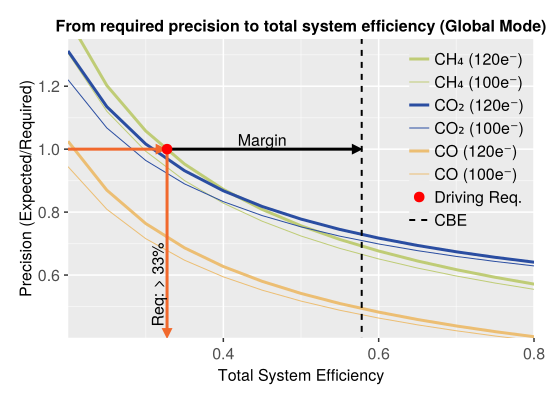

In [16]:
# Just plotting the data, TLDR
f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Total System Efficiency", ylabel="Precision (Expected/Required)",  title="From required precision to total system efficiency (Global Mode)")
# For CH4 (100 and 120e-)
lines!(ax, TotalEfficiencies, gas_errors_120[1,:]./ch4_req_ppb, color=CarbonI_colors[7], linewidth=3, label="CH₄ (120e⁻)")
lines!(ax, TotalEfficiencies, gas_errors_100[1,:]./ch4_req_ppb, color=CarbonI_colors[7], linewidth=1, label="CH₄ (100e⁻)")
# For CO2 (100 and 120e-)
lines!(ax, TotalEfficiencies, gas_errors_120[2,:]./co2_req_ppb, color=CarbonI_colors[4], linewidth=3, label="CO₂ (120e⁻)")
lines!(ax, TotalEfficiencies, gas_errors_100[2,:]./co2_req_ppb, color=CarbonI_colors[4], linewidth=1, label="CO₂ (100e⁻)")
# For CO (100 and 120e-)
lines!(ax, TotalEfficiencies, gas_errors_120[3,:]./co_req_ppb, color=CarbonI_colors[6], linewidth=3, label="CO (120e⁻)")
lines!(ax, TotalEfficiencies, gas_errors_100[3,:]./co_req_ppb, color=CarbonI_colors[6], linewidth=1, label="CO (100e⁻)")

# Lines for Driving Requirement
arrows!(ax, [0.0,],[1,],[req_eff-0.01,],[0,],arrowsize = 15, linewidth=3, color = CarbonI_colors[5])
arrows!(ax, [req_eff,],[req_error,],[0,],[-req_error+0.42,],arrowsize = 15, linewidth=3,color = CarbonI_colors[5])
text!(ax, "Req: > $(round(Int, 100req_eff))%", position = (req_eff, 0.57),
    align = (:center, :bottom), color = :black, rotation=π/2)

# Indicate Margins
arrows!(ax, [req_eff+0.002,],[req_error,],[eff_cbe-req_eff-0.01,],[0,],arrowsize = 15, linewidth=3, color = :black)
text!(ax, "Margin", position = (0.45, req_error),  align = (:center, :bottom), color = :black)
scatter!(ax, [req_eff], [req_error], color=:red, markersize=15, label="Driving Req.")
# Show CBE Total Efficiency
lines!(ax, [eff_cbe,eff_cbe], [0,1.35], color=:black, linestyle=:dash, linewidth=2, label="CBE")

xlims!(ax,0.2,0.8)
ylims!(ax,0.4,1.35)
axislegend(ax,position = :rt)
save("../../plots/final/Level1-1-EfficiencyDerivation_perGas.pdf",f)
f

In [17]:
# Save lines to merge later with other requirements:
AllData = [TotalEfficiencies gas_errors_120[1,:]./ch4_req_ppb  gas_errors_100[1,:]./ch4_req_ppb gas_errors_120[2,:]./co2_req_ppb gas_errors_100[2,:]./co2_req_ppb gas_errors_120[3,:]./co_req_ppb   gas_errors_100[3,:]./co_req_ppb];
writedlm("../../data/L1s/L1-1_lines.dat", AllData)

In [18]:
from_w_to_photons = 5.03e12 # Conversion factor from mW/m²/nm/sr to photons/m²/sr/nm at a specific wavelength (choice is irrelevant here)
refRadiance = 1.0e16 # in photons/s/m²/nm

# Compute the instrumenyt models again:
ins_req_forSNR = InstrumentOperator.createGratingNoiseModel(44.0u"ms", req_specs.Pitch, 1.0, req_eff, req_specs.Fnumber, 2*req_specs.SSI, (120.0), req_specs.dark_current);
ins_cbe_forSNR = InstrumentOperator.createGratingNoiseModel(44.0u"ms", cbe_specs.Pitch, 1.0, eff_cbe, cbe_specs.Fnumber, 2*cbe_specs.SSI, (100.0), cbe_specs.dark_current);

# Use reference Wavelength here (just for conversion)
ref_wl = 2250;


refRadiance_mw = refRadiance / from_w_to_photons / ref_wl
nesr_req_forSNR = InstrumentOperator.noise_equivalent_radiance(ins_req_forSNR, (ref_wl)u"nm", (refRadiance_mw)u"mW/m^2/nm/sr");
nesr_cbe_forSNR = InstrumentOperator.noise_equivalent_radiance(ins_cbe_forSNR, (ref_wl)u"nm", (refRadiance_mw)u"mW/m^2/nm/sr");

@printf("Required SNR @1e16 photons/m²/sr/nm/s: %.4g\n",  refRadiance_mw/(nesr_req_forSNR[1]./1u"mW/m^2/nm/sr"))
@printf("CBE      SNR @1e16 photons/m²/sr/nm/s: %.4g ",  refRadiance_mw/(nesr_cbe_forSNR[1]./1u"mW/m^2/nm/sr"))


Required SNR @1e16 photons/m²/sr/nm/s: 66.83
CBE      SNR @1e16 photons/m²/sr/nm/s: 110.3 

---

### Compute performance of the CBE design

In [19]:
# Going back full circle from CBE to expected L1 values

# For CH4
ch4_error_ppb = (error_cbe["ch4"]/sqrt(cbe_specs.coadd_rate))u"ppb"
flux_ch4_cbe_limit = uconvert(u"kg/hr", ch4_error_ppb * C.p /(C.g*m.air) * cbe_pix * m.ch4 * wind_speed * q )

# For CO2:
co2_error_ppb = (error_cbe["co2"]/sqrt(cbe_specs.coadd_rate))u"ppb"
flux_co2_cbe_limit = uconvert(u"kg/hr", co2_error_ppb * C.p /(C.g*m.air) * cbe_pix * m.co2 * wind_speed * q )

# For CO:
co_error_ppb = (error_cbe["co"]/sqrt(cbe_specs.coadd_rate))u"ppb"
flux_co_cbe_limit = uconvert(u"kg/hr", co_error_ppb * C.p /(C.g*m.air) * cbe_pix * m.co * wind_speed * q)

# Show the results:
@printf("CBE Flux Detection for CH₄ : %.3g kg/hr \n", ustrip(flux_ch4_cbe_limit)) 
@printf("CBE Flux Detection for CO₂ : %.3g kg/hr \n", ustrip(flux_co2_cbe_limit))
@printf("CBE Flux Detection for CO  : %.3g kg/hr",   ustrip(flux_co_cbe_limit))

CBE Flux Detection for CH₄ : 84.5 kg/hr 
CBE Flux Detection for CO₂ : 5.01e+04 kg/hr 
CBE Flux Detection for CO  : 619 kg/hr

---

### Summary Stats:

In [20]:
# Convert everything to the display units you want first
σ_ch4_req_ppb = ustrip(uconvert(u"ppb", σ_ch4_req))
σ_co2_req_ppm = ustrip(uconvert(u"ppm", σ_co2_req))
σ_co_req_ppb  = ustrip(uconvert(u"ppb", σ_co_req))

σ_ch4_exp_ppb = error_cbe["ch4"] / sqrtN
σ_co2_exp_ppm = error_cbe["co2"] / 1000 / sqrtN
σ_co_exp_ppb  = error_cbe["co"]  / sqrtN

rows = [
    (gas="CH₄", unit="ppb", req=σ_ch4_req_ppb, exp=σ_ch4_exp_ppb),
    (gas="CO₂", unit="ppm", req=σ_co2_req_ppm, exp=σ_co2_exp_ppm),
    (gas="CO",  unit="ppb", req=σ_co_req_ppb,  exp=σ_co_exp_ppb),
]

req_vs_exp_table(rows; sigdigits=3, render=:markdown)

| Gas | Required σ | Expected σ | Margin wrt to CBE | Margin wrt to REQ |  Unit |
|-----|-----------:|-----------:|-------:|-------:|------|
| CH₄ | 5.38 | 3.22 | -67.4% | +40.3% |ppb |
| CO₂ | 1.12 | 0.695 | -61.3% | +38.0% |ppm |
| CO | 30.8 | 13.5 | -128.5% | +56.2% |ppb |


In [21]:
# SNR benchmarking
@printf("Required SNR @1e16 photons/m²/sr/nm/s: %.4g\n",  refRadiance_mw/(nesr_req_forSNR[1]./1u"mW/m^2/nm/sr"))
@printf("CBE      SNR @1e16 photons/m²/sr/nm/s: %.4g ",  refRadiance_mw/(nesr_cbe_forSNR[1]./1u"mW/m^2/nm/sr"))

Required SNR @1e16 photons/m²/sr/nm/s: 66.83
CBE      SNR @1e16 photons/m²/sr/nm/s: 110.3 

In [22]:
@printf("Required total system efficiency: %.2f%%\n", 100*req_eff);

Required total system efficiency: 32.75%
